<a href="https://colab.research.google.com/github/shaheer1995/Hyperspectral-Classification/blob/master/HamidaEtAl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Clone the Repository and Install Required Packages


In [16]:
!git clone "https://github.com/shaheer1995/Hyperspectral-Classification"
!pip install spectral==0.19 
!pip install visdom==0.1.5
%cd /content/Hyperspectral-Classification/
%mkdir Datasets

Cloning into 'Hyperspectral-Classification'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 77 (delta 26), reused 11 (delta 5), pack-reused 23
Unpacking objects: 100% (77/77), done.
/content/Hyperspectral-Classification
mkdir: cannot create directory ‘Datasets’: File exists


### Import Libraries

In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.nn import init
import math
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from tqdm import tqdm
from datasets import get_dataset, HyperX, open_file, DATASETS_CONFIG
from utils import metrics, convert_to_color_, convert_from_color_,\
    display_dataset, display_predictions, explore_spectrums, plot_spectrums,\
    sample_gt, build_dataset, show_results, compute_imf_weights, get_device
from models import get_model, train, test, save_model
import warnings
import torch.utils.data as data
from torchsummary import summary
import visdom

### Set the Hyperparameters

In [18]:
DATASET = 'PaviaU'
FOLDER = '/content/Hyperspectral-Classification/Datasets/'
SAMPLE_PERCENTAGE = 0.2
SAMPLING_MODE = 'random'
CUDA_DEVICE = 0
EPOCH = 300
PATCH_SIZE = 5
LEARNING_RATE = 0.01
BATCH_SIZE = 100
CHECKPOINT = None

### Load the dataset

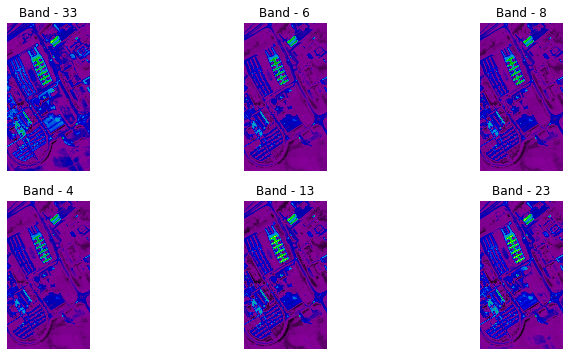

In [19]:
img, gt, LABEL_VALUES, IGNORED_LABELS, RGB_BANDS, palette = get_dataset(DATASET,FOLDER)

fig = plt.figure(figsize = (12, 6))
for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(img.shape[2])
    plt.imshow(img[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.savefig('IP_Bands.png')

In [20]:
warnings.filterwarnings("ignore")
# Number of classes
N_CLASSES = len(LABEL_VALUES)
# Number of bands (last dimension of the image tensor)
N_BANDS = img.shape[-1]

if palette is None:
    # Generate color palette
    palette = {0: (0, 0, 0)}
    for k, color in enumerate(sns.color_palette("hls", len(LABEL_VALUES) - 1)):
        palette[k + 1] = tuple(np.asarray(255 * np.array(color), dtype='uint8'))
invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(x):
    return convert_to_color_(x, palette=palette)
def convert_from_color(x):
    return convert_from_color_(x, palette=invert_palette)

### Split Test and Train Datasets

8555 samples selected (over 42776)


(-0.5, 339.5, 609.5, -0.5)

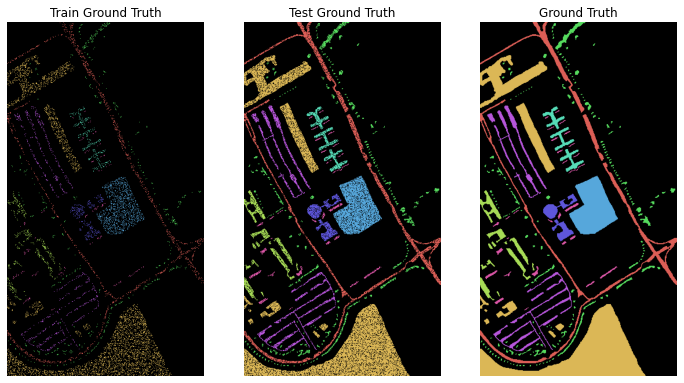

In [21]:
# Sample random training spectra
train_gt, test_gt = sample_gt(gt,SAMPLE_PERCENTAGE, mode=SAMPLING_MODE)
print("{} samples selected (over {})".format(np.count_nonzero(train_gt), np.count_nonzero(gt)))
fig = plt.figure(figsize = (12, 18))

fig.add_subplot(1,3,1)
plt.imshow(convert_to_color(train_gt), cmap='nipy_spectral')
plt.title('Train Ground Truth')
plt.axis('off')
fig.add_subplot(1,3,2)
plt.imshow(convert_to_color(test_gt), cmap='nipy_spectral')
plt.title('Test Ground Truth')
plt.axis('off')
fig.add_subplot(1,3,3)
plt.imshow(convert_to_color(gt), cmap='nipy_spectral')
plt.title('Ground Truth')
plt.axis('off')

### HamidaEtAl 6 Layer Model 

In [22]:
class HamidaEtAl(nn.Module):
    """
    3-D Deep Learning Approach for Remote Sensing Image Classification
    Amina Ben Hamida, Alexandre Benoit, Patrick Lambert, Chokri Ben Amar
    IEEE TGRS, 2018
    https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8344565
    """
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d):
            init.kaiming_normal_(m.weight)
            init.zeros_(m.bias)

    def __init__(self, input_channels, n_classes, patch_size=5, dilation=1):
        super(HamidaEtAl, self).__init__()
        # The first layer is a (3,3,3) kernel sized Conv characterized
        # by a stride equal to 1 and number of neurons equal to 20
        self.patch_size = patch_size
        self.input_channels = input_channels
        dilation = (dilation, 1, 1)

        if patch_size == 3:
            self.conv1 = nn.Conv3d(
                1, 20, (3, 3, 3), stride=(1, 1, 1), dilation=dilation, padding=1)
        else:
            self.conv1 = nn.Conv3d(
                1, 20, (3, 3, 3), stride=(1, 1, 1), dilation=dilation, padding=0)
        # Next pooling is applied using a layer identical to the previous one
        # with the difference of a 1D kernel size (1,1,3) and a larger stride
        # equal to 2 in order to reduce the spectral dimension
        self.pool1 = nn.Conv3d(
            20, 20, (3, 1, 1), dilation=dilation, stride=(2, 1, 1), padding=(1, 0, 0))
        # Then, a duplicate of the first and second layers is created with
        # 35 hidden neurons per layer.
        self.conv2 = nn.Conv3d(
            20, 35, (3, 3, 3), dilation=dilation, stride=(1, 1, 1), padding=(1, 0, 0))
        self.pool2 = nn.Conv3d(
            35, 35, (3, 1, 1), dilation=dilation, stride=(2, 1, 1), padding=(1, 0, 0))
        # Finally, the 1D spatial dimension is progressively reduced
        # thanks to the use of two Conv layers, 35 neurons each,
        # with respective kernel sizes of (1,1,3) and (1,1,2) and strides
        # respectively equal to (1,1,1) and (1,1,2)
        self.conv3 = nn.Conv3d(
            35, 35, (3, 1, 1), dilation=dilation, stride=(1, 1, 1), padding=(1, 0, 0))
        self.conv4 = nn.Conv3d(
            35, 35, (2, 1, 1), dilation=dilation, stride=(2, 1, 1), padding=(1, 0, 0))

        #self.dropout = nn.Dropout(p=0.5)

        self.features_size = self._get_final_flattened_size()
        # The architecture ends with a fully connected layer where the number
        # of neurons is equal to the number of input classes.
        self.fc = nn.Linear(self.features_size, n_classes)

        self.apply(self.weight_init)

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros((1, 1, self.input_channels,
                             self.patch_size, self.patch_size))
            x = self.pool1(self.conv1(x))
            x = self.pool2(self.conv2(x))
            x = self.conv3(x)
            x = self.conv4(x)
            _, t, c, w, h = x.size()
        return t * c * w * h

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self.features_size)
        #x = self.dropout(x)
        x = self.fc(x)
        return x

### HamidaEtAl 8 Layer Model

In [23]:
class HamidaEtAl8x8(nn.Module):
    """
    3-D Deep Learning Approach for Remote Sensing Image Classification
    Amina Ben Hamida, Alexandre Benoit, Patrick Lambert, Chokri Ben Amar
    IEEE TGRS, 2018
    https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8344565
    """
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d):
            init.kaiming_normal_(m.weight)
            init.zeros_(m.bias)

    def __init__(self, input_channels, n_classes, patch_size=5, dilation=1):
        super(HamidaEtAl8x8, self).__init__()
        # The first layer is a (3,3,3) kernel sized Conv characterized
        # by a stride equal to 1 and number of neurons equal to 20
        self.patch_size = patch_size
        self.input_channels = input_channels
        dilation = (dilation, 1, 1)

        
        
        self.conv1 = nn.Conv3d(1, 20, (3, 3, 3), stride=(1, 1, 1), dilation=dilation, padding=(1, 0, 0))
    
        self.conv2 = nn.Conv3d(20, 2, (3, 1, 1), stride=(2, 1, 1), dilation=dilation, padding=(1, 0, 0))

        self.conv3 = nn.Conv3d(2, 35, (3, 3, 3), stride=(1, 1, 1), dilation=dilation, padding=(1, 1, 1))

        self.conv4 = nn.Conv3d(35, 2, (2, 1, 1), stride=(2, 1, 1), dilation=dilation, padding=(1, 0, 0))

        self.conv5 = nn.Conv3d(2, 35, (3, 1, 1), stride=(1, 1, 1), dilation=dilation, padding=(1, 0, 0))

        self.conv6 = nn.Conv3d(35, 2, (1, 1, 1), stride=(2, 1, 1), dilation=dilation, padding=(1, 0, 0))

        self.conv7 = nn.Conv3d(2, 35, (3, 1, 1), stride=(1, 1, 1), dilation=dilation, padding=(1, 0, 0))

        self.conv8 = nn.Conv3d(35, 4, (1, 1, 1), stride=(2, 2, 2), dilation=dilation, padding=(0, 0, 0))

        self.features_size = self._get_final_flattened_size()
        # The architecture ends with a fully connected layer where the number
        # of neurons is equal to the number of input classes.
        self.fc = nn.Linear(self.features_size, n_classes)

        self.apply(self.weight_init)

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros((1, 1, self.input_channels,
                             self.patch_size, self.patch_size))
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            x = self.conv5(x)
            x = self.conv6(x)
            x = self.conv7(x)
            x = self.conv8(x)
            _, t, c, w, h = x.size()
        return t * c * w * h

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = x.view(-1, self.features_size)
        #x = self.dropout(x)
        x = self.fc(x)
        return x

In [24]:
if torch.cuda.is_available():
        print("Computation on CUDA GPU device {}".format(CUDA_DEVICE))
        device = torch.device('cuda:{}'.format(CUDA_DEVICE))
else:
    print("/!\\ CUDA was requested but is not available! Computation will go on CPU. /!\\")
    device = torch.device('cpu')

Computation on CUDA GPU device 0


In [25]:
hyperparams = {'dataset': 'PaviaU', 'model': 'hamida', 'folder': './Datasets/', 'cuda': 0, 'runs': 1, 'restore': None, 'training_sample': 0.5, 'sampling_mode': 'random', 'train_set': None, 'test_set': None, 'epoch': EPOCH, 'patch_size': PATCH_SIZE, 'lr': None, 'class_balancing': False, 'batch_size': None, 'test_stride': 1, 'flip_augmentation': False, 'radiation_augmentation': False, 'mixture_augmentation': False, 'with_exploration': False, 'download': None}
# Instantiate the experiment based on predefined networks
hyperparams.update({'n_classes': N_CLASSES, 'n_bands': N_BANDS, 'ignored_labels': IGNORED_LABELS, 'device': CUDA_DEVICE})
hyperparams = dict((k, v) for k, v in hyperparams.items() if v is not None)
print(hyperparams)

{'dataset': 'PaviaU', 'model': 'hamida', 'folder': './Datasets/', 'cuda': 0, 'runs': 1, 'training_sample': 0.5, 'sampling_mode': 'random', 'epoch': 300, 'patch_size': 5, 'class_balancing': False, 'test_stride': 1, 'flip_augmentation': False, 'radiation_augmentation': False, 'mixture_augmentation': False, 'with_exploration': False, 'n_classes': 10, 'n_bands': 103, 'ignored_labels': [0], 'device': 0}


In [26]:
model = HamidaEtAl8x8(103, 10, patch_size=5)
model = model.to(device)
print(model)

HamidaEtAl8x8(
  (conv1): Conv3d(1, 20, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv2): Conv3d(20, 2, kernel_size=(3, 1, 1), stride=(2, 1, 1), padding=(1, 0, 0))
  (conv3): Conv3d(2, 35, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4): Conv3d(35, 2, kernel_size=(2, 1, 1), stride=(2, 1, 1), padding=(1, 0, 0))
  (conv5): Conv3d(2, 35, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv6): Conv3d(35, 2, kernel_size=(1, 1, 1), stride=(2, 1, 1), padding=(1, 0, 0))
  (conv7): Conv3d(2, 35, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv8): Conv3d(35, 4, kernel_size=(1, 1, 1), stride=(2, 2, 2))
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [27]:
n_classes = hyperparams['n_classes']
n_bands = hyperparams['n_bands']
weights = torch.ones(n_classes)
weights[torch.LongTensor(hyperparams['ignored_labels'])] = 0.
weights = weights.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0005)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0.0005
)


In [28]:
hyperparams.update({'weights': weights, 'lr': LEARNING_RATE, 'batch_size': BATCH_SIZE, 'supervision': 'full','scheduler':optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=EPOCH//4, verbose=True), 'center_pixel':True})
print(hyperparams)
loss = nn.CrossEntropyLoss(hyperparams['weights'])
print(loss)

{'dataset': 'PaviaU', 'model': 'hamida', 'folder': './Datasets/', 'cuda': 0, 'runs': 1, 'training_sample': 0.5, 'sampling_mode': 'random', 'epoch': 300, 'patch_size': 5, 'class_balancing': False, 'test_stride': 1, 'flip_augmentation': False, 'radiation_augmentation': False, 'mixture_augmentation': False, 'with_exploration': False, 'n_classes': 10, 'n_bands': 103, 'ignored_labels': [0], 'device': 0, 'weights': tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0'), 'lr': 0.01, 'batch_size': 100, 'supervision': 'full', 'scheduler': <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f16580e4d30>, 'center_pixel': True}
CrossEntropyLoss()


In [29]:
print("Running an experiment with the {} model".format('HamidaEtAl'))
results = []
# Split train set in train/val
train_gt, val_gt = sample_gt(train_gt, 0.95, mode='random')
# Generate the dataset
train_dataset = HyperX(img, train_gt, **hyperparams)
train_loader = data.DataLoader(train_dataset,
                                batch_size=hyperparams['batch_size'],
                                #pin_memory=hyperparams['device'],
                                shuffle=True)
val_dataset = HyperX(img, val_gt, **hyperparams)
val_loader = data.DataLoader(val_dataset,
                              #pin_memory=hyperparams['device'],
                              batch_size=hyperparams['batch_size'])
print("****************** Model *********************")
print(model)
print("***********************************************")
print(hyperparams)
print("Network :")
with torch.no_grad():
    for input, _ in train_loader:
        break
    #summary(model.to(hyperparams['device']), input.size()[1:], device=hyperparams['device'])
    summary(model.to(hyperparams['device']), input.size()[1:])

if CHECKPOINT is not None:
    model.load_state_dict(torch.load(CHECKPOINT))
viz = visdom.Visdom(env=DATASET + ' ' + 'HamidaEtAl')
try:
    train(model, optimizer, loss, train_loader, hyperparams['epoch'],
          scheduler=hyperparams['scheduler'], device=hyperparams['device'],
          supervision=hyperparams['supervision'], val_loader=val_loader,
          display=viz)
except KeyboardInterrupt:
    # Allow the user to stop the training
    pass

probabilities = test(model, img, hyperparams)
prediction = np.argmax(probabilities, axis=-1)

run_results = metrics(prediction, test_gt, ignored_labels=hyperparams['ignored_labels'], n_classes=N_CLASSES)

mask = np.zeros(gt.shape, dtype='bool')
for l in IGNORED_LABELS:
    mask[gt == l] = True
prediction[mask] = 0

color_prediction = convert_to_color(prediction)
# display_predictions(B, viz, gt=convert_to_color(test_gt), caption="Prediction vs. test ground truth")

results.append(run_results)
# show_results(run_results, viz, label_values=LABEL_VALUES)

Running an experiment with the HamidaEtAl model
****************** Model *********************
HamidaEtAl8x8(
  (conv1): Conv3d(1, 20, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv2): Conv3d(20, 2, kernel_size=(3, 1, 1), stride=(2, 1, 1), padding=(1, 0, 0))
  (conv3): Conv3d(2, 35, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4): Conv3d(35, 2, kernel_size=(2, 1, 1), stride=(2, 1, 1), padding=(1, 0, 0))
  (conv5): Conv3d(2, 35, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv6): Conv3d(35, 2, kernel_size=(1, 1, 1), stride=(2, 1, 1), padding=(1, 0, 0))
  (conv7): Conv3d(2, 35, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv8): Conv3d(35, 4, kernel_size=(1, 1, 1), stride=(2, 2, 2))
  (fc): Linear(in_features=128, out_features=10, bias=True)
)
***********************************************
{'dataset': 'PaviaU', 'model': 'hamida', 'folder': './Datasets/', 'cuda': 0, 'runs': 1, 'training_sample': 0.5, 'sampli

 15%|█▌        | 12/80 [00:00<00:00, 111.86it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 2/300) [1900/8000 (24%)]	Loss: 1.597243
Exception in user code:
------------------------------------------------------------



 40%|████      | 32/80 [00:00<00:00, 102.12it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 3/300) [3900/8000 (49%)]	Loss: 1.063951
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 109.17it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 4/300) [5900/8000 (74%)]	Loss: 0.925560
Exception in user code:
------------------------------------------------------------



 98%|█████████▊| 78/80 [00:00<00:00, 102.42it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 5/300) [1027/1040 (99%)]	Loss: 0.862653
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 113.02it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 7/300) [1900/8000 (24%)]	Loss: 0.833396
Exception in user code:
------------------------------------------------------------



 45%|████▌     | 36/80 [00:00<00:00, 115.09it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 8/300) [3900/8000 (49%)]	Loss: 0.779864
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 107.13it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 9/300) [5900/8000 (74%)]	Loss: 0.728760
Exception in user code:
------------------------------------------------------------


 89%|████████▉ | 71/80 [00:00<00:00, 111.93it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 10/300) [1027/1040 (99%)]	Loss: 0.687552
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 112.79it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 12/300) [1900/8000 (24%)]	Loss: 0.657327
Exception in user code:
------------------------------------------------------------



 45%|████▌     | 36/80 [00:00<00:00, 113.39it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 13/300) [3900/8000 (49%)]	Loss: 0.627741
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 108.30it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 14/300) [5900/8000 (74%)]	Loss: 0.599964
Exception in user code:
------------------------------------------------------------


 86%|████████▋ | 69/80 [00:00<00:00, 110.83it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 15/300) [1027/1040 (99%)]	Loss: 0.575008
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch15_0.60



 14%|█▍        | 11/80 [00:00<00:00, 107.90it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 17/300) [1900/8000 (24%)]	Loss: 0.565428
Exception in user code:
------------------------------------------------------------



 45%|████▌     | 36/80 [00:00<00:00, 111.61it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 18/300) [3900/8000 (49%)]	Loss: 0.520194
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 111.00it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 19/300) [5900/8000 (74%)]	Loss: 0.513360
Exception in user code:
------------------------------------------------------------


 86%|████████▋ | 69/80 [00:00<00:00, 110.08it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 20/300) [1027/1040 (99%)]	Loss: 0.475759
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 116.99it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 22/300) [1900/8000 (24%)]	Loss: 0.481115
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 110.41it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 23/300) [3900/8000 (49%)]	Loss: 0.445124
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 107.06it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 24/300) [5900/8000 (74%)]	Loss: 0.411725
Exception in user code:
------------------------------------------------------------


 96%|█████████▋| 77/80 [00:00<00:00, 107.60it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 25/300) [1027/1040 (99%)]	Loss: 0.403561
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 114.86it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 27/300) [1900/8000 (24%)]	Loss: 0.402036
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 112.02it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 28/300) [3900/8000 (49%)]	Loss: 0.350804
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 109.48it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 29/300) [5900/8000 (74%)]	Loss: 0.357617
Exception in user code:
------------------------------------------------------------


 99%|█████████▉| 79/80 [00:00<00:00, 108.71it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 30/300) [1027/1040 (99%)]	Loss: 0.334164
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch30_0.72



 15%|█▌        | 12/80 [00:00<00:00, 114.35it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 32/300) [1900/8000 (24%)]	Loss: 0.317891
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 112.05it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 33/300) [3900/8000 (49%)]	Loss: 0.299578
Exception in user code:
------------------------------------------------------------



 72%|███████▎  | 58/80 [00:00<00:00, 109.97it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 34/300) [5900/8000 (74%)]	Loss: 0.326108
Exception in user code:
------------------------------------------------------------



 88%|████████▊ | 70/80 [00:00<00:00, 109.94it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 35/300) [1027/1040 (99%)]	Loss: 0.277382
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 111.41it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 37/300) [1900/8000 (24%)]	Loss: 0.287590
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 111.63it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 38/300) [3900/8000 (49%)]	Loss: 0.253354
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 109.80it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 39/300) [5900/8000 (74%)]	Loss: 0.237810
Exception in user code:
------------------------------------------------------------



 98%|█████████▊| 78/80 [00:00<00:00, 106.22it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 40/300) [1027/1040 (99%)]	Loss: 0.214909
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 115.46it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 42/300) [1900/8000 (24%)]	Loss: 0.253584
Exception in user code:
------------------------------------------------------------



 41%|████▏     | 33/80 [00:00<00:00, 106.52it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 43/300) [3900/8000 (49%)]	Loss: 0.198986
Exception in user code:
------------------------------------------------------------



 69%|██████▉   | 55/80 [00:00<00:00, 105.97it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 44/300) [5900/8000 (74%)]	Loss: 0.219483
Exception in user code:
------------------------------------------------------------


 86%|████████▋ | 69/80 [00:00<00:00, 110.18it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 45/300) [1027/1040 (99%)]	Loss: 0.190924
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch45_0.90



 15%|█▌        | 12/80 [00:00<00:00, 114.75it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 47/300) [1900/8000 (24%)]	Loss: 0.178766
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 111.54it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 48/300) [3900/8000 (49%)]	Loss: 0.230713
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 109.96it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 49/300) [5900/8000 (74%)]	Loss: 0.212612
Exception in user code:
------------------------------------------------------------


 96%|█████████▋| 77/80 [00:00<00:00, 106.98it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 50/300) [1027/1040 (99%)]	Loss: 0.173611
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 115.90it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 52/300) [1900/8000 (24%)]	Loss: 0.174429
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 111.23it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 53/300) [3900/8000 (49%)]	Loss: 0.179744
Exception in user code:
------------------------------------------------------------



 72%|███████▎  | 58/80 [00:00<00:00, 109.58it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 54/300) [5900/8000 (74%)]	Loss: 0.140431
Exception in user code:
------------------------------------------------------------



 99%|█████████▉| 79/80 [00:00<00:00, 107.90it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 55/300) [1027/1040 (99%)]	Loss: 0.157864
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 112.71it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 57/300) [1900/8000 (24%)]	Loss: 0.216847
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 110.82it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 58/300) [3900/8000 (49%)]	Loss: 0.135444
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 109.30it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 59/300) [5900/8000 (74%)]	Loss: 0.166954
Exception in user code:
------------------------------------------------------------


 96%|█████████▋| 77/80 [00:00<00:00, 104.33it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 60/300) [1027/1040 (99%)]	Loss: 0.113861
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch60_0.96



 14%|█▍        | 11/80 [00:00<00:00, 104.85it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 62/300) [1900/8000 (24%)]	Loss: 0.150950
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 108.06it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 63/300) [3900/8000 (49%)]	Loss: 0.130025
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 106.67it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 64/300) [5900/8000 (74%)]	Loss: 0.163788
Exception in user code:
------------------------------------------------------------


 99%|█████████▉| 79/80 [00:00<00:00, 109.46it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 65/300) [1027/1040 (99%)]	Loss: 0.122506
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 112.97it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 67/300) [1900/8000 (24%)]	Loss: 0.099635
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 109.84it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 68/300) [3900/8000 (49%)]	Loss: 0.125365
Exception in user code:
------------------------------------------------------------



 69%|██████▉   | 55/80 [00:00<00:00, 105.70it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 69/300) [5900/8000 (74%)]	Loss: 0.140960
Exception in user code:
------------------------------------------------------------


 85%|████████▌ | 68/80 [00:00<00:00, 109.69it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 70/300) [1027/1040 (99%)]	Loss: 0.098435
Exception in user code:
------------------------------------------------------------



 14%|█▍        | 11/80 [00:00<00:00, 109.72it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 72/300) [1900/8000 (24%)]	Loss: 0.131538
Exception in user code:
------------------------------------------------------------



 41%|████▏     | 33/80 [00:00<00:00, 102.72it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 73/300) [3900/8000 (49%)]	Loss: 0.194942
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 108.28it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 74/300) [5900/8000 (74%)]	Loss: 0.165856
Exception in user code:
------------------------------------------------------------


 86%|████████▋ | 69/80 [00:00<00:00, 110.27it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 75/300) [1027/1040 (99%)]	Loss: 0.133157
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch75_0.92


 15%|█▌        | 12/80 [00:00<00:00, 116.55it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 77/300) [1900/8000 (24%)]	Loss: 0.145892
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 110.62it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 78/300) [3900/8000 (49%)]	Loss: 0.106433
Exception in user code:
------------------------------------------------------------



 74%|███████▍  | 59/80 [00:00<00:00, 110.18it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 79/300) [5900/8000 (74%)]	Loss: 0.136095
Exception in user code:
------------------------------------------------------------



 86%|████████▋ | 69/80 [00:00<00:00, 109.92it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 80/300) [1027/1040 (99%)]	Loss: 0.092624
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 114.37it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 82/300) [1900/8000 (24%)]	Loss: 0.123088
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 111.54it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 83/300) [3900/8000 (49%)]	Loss: 0.088618
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 109.93it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 84/300) [5900/8000 (74%)]	Loss: 0.163659
Exception in user code:
------------------------------------------------------------


 86%|████████▋ | 69/80 [00:00<00:00, 110.47it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 85/300) [1027/1040 (99%)]	Loss: 0.131155
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 114.54it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 87/300) [1900/8000 (24%)]	Loss: 0.092143
Exception in user code:
------------------------------------------------------------



 45%|████▌     | 36/80 [00:00<00:00, 114.47it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 88/300) [3900/8000 (49%)]	Loss: 0.088634
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 111.03it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 89/300) [5900/8000 (74%)]	Loss: 0.091117
Exception in user code:
------------------------------------------------------------



 99%|█████████▉| 79/80 [00:00<00:00, 103.58it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 90/300) [1027/1040 (99%)]	Loss: 0.085767
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch90_0.98



 15%|█▌        | 12/80 [00:00<00:00, 111.77it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 92/300) [1900/8000 (24%)]	Loss: 0.071893
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 111.40it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 93/300) [3900/8000 (49%)]	Loss: 0.160556
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 108.45it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 94/300) [5900/8000 (74%)]	Loss: 0.106204
Exception in user code:
------------------------------------------------------------


 89%|████████▉ | 71/80 [00:00<00:00, 111.48it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 95/300) [1027/1040 (99%)]	Loss: 0.151754
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 113.88it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 97/300) [1900/8000 (24%)]	Loss: 0.123401
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 110.54it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 98/300) [3900/8000 (49%)]	Loss: 0.145638
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 110.59it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 99/300) [5900/8000 (74%)]	Loss: 0.076063
Exception in user code:
------------------------------------------------------------


 99%|█████████▉| 79/80 [00:00<00:00, 109.71it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 100/300) [1027/1040 (99%)]	Loss: 0.066253
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 112.53it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 102/300) [1900/8000 (24%)]	Loss: 0.113240
Exception in user code:
------------------------------------------------------------



 45%|████▌     | 36/80 [00:00<00:00, 112.37it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 103/300) [3900/8000 (49%)]	Loss: 0.077246
Exception in user code:
------------------------------------------------------------



 74%|███████▍  | 59/80 [00:00<00:00, 110.45it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 104/300) [5900/8000 (74%)]	Loss: 0.120025
Exception in user code:
------------------------------------------------------------


 89%|████████▉ | 71/80 [00:00<00:00, 111.45it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 105/300) [1027/1040 (99%)]	Loss: 0.075360
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch105_0.98



 15%|█▌        | 12/80 [00:00<00:00, 114.55it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 107/300) [1900/8000 (24%)]	Loss: 0.069955
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 111.48it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 108/300) [3900/8000 (49%)]	Loss: 0.062810
Exception in user code:
------------------------------------------------------------



 74%|███████▍  | 59/80 [00:00<00:00, 110.54it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 109/300) [5900/8000 (74%)]	Loss: 0.143545
Exception in user code:
------------------------------------------------------------



 86%|████████▋ | 69/80 [00:00<00:00, 109.94it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 110/300) [1027/1040 (99%)]	Loss: 0.064640
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 115.06it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 112/300) [1900/8000 (24%)]	Loss: 0.076604
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 110.68it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 113/300) [3900/8000 (49%)]	Loss: 0.130889
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 110.10it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 114/300) [5900/8000 (74%)]	Loss: 0.078460
Exception in user code:
------------------------------------------------------------


 85%|████████▌ | 68/80 [00:00<00:00, 108.07it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 115/300) [1027/1040 (99%)]	Loss: 0.065731
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 110.73it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 117/300) [1900/8000 (24%)]	Loss: 0.060970
Exception in user code:
------------------------------------------------------------



 45%|████▌     | 36/80 [00:00<00:00, 113.07it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 118/300) [3900/8000 (49%)]	Loss: 0.229821
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 109.63it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 119/300) [5900/8000 (74%)]	Loss: 0.083425
Exception in user code:
------------------------------------------------------------



 88%|████████▊ | 70/80 [00:00<00:00, 111.56it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 120/300) [1027/1040 (99%)]	Loss: 0.072917
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch120_0.88



 15%|█▌        | 12/80 [00:00<00:00, 113.85it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 122/300) [1900/8000 (24%)]	Loss: 0.102160
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 111.78it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 123/300) [3900/8000 (49%)]	Loss: 0.068949
Exception in user code:
------------------------------------------------------------



 72%|███████▎  | 58/80 [00:00<00:00, 111.31it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 124/300) [5900/8000 (74%)]	Loss: 0.088174
Exception in user code:
------------------------------------------------------------



 99%|█████████▉| 79/80 [00:00<00:00, 109.85it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 125/300) [1027/1040 (99%)]	Loss: 0.060204
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 113.98it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 127/300) [1900/8000 (24%)]	Loss: 0.110084
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 111.87it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 128/300) [3900/8000 (49%)]	Loss: 0.121472
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 109.20it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 129/300) [5900/8000 (74%)]	Loss: 0.068558
Exception in user code:
------------------------------------------------------------


 88%|████████▊ | 70/80 [00:00<00:00, 110.65it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 130/300) [1027/1040 (99%)]	Loss: 0.062713
Exception in user code:
------------------------------------------------------------



 14%|█▍        | 11/80 [00:00<00:00, 109.94it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 132/300) [1900/8000 (24%)]	Loss: 0.073042
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 109.67it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 133/300) [3900/8000 (49%)]	Loss: 0.064978
Exception in user code:
------------------------------------------------------------



 72%|███████▎  | 58/80 [00:00<00:00, 111.83it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 134/300) [5900/8000 (74%)]	Loss: 0.058050
Exception in user code:
------------------------------------------------------------



 99%|█████████▉| 79/80 [00:00<00:00, 105.54it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 135/300) [1027/1040 (99%)]	Loss: 0.144979
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch135_0.98



 15%|█▌        | 12/80 [00:00<00:00, 112.28it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 137/300) [1900/8000 (24%)]	Loss: 0.065760
Exception in user code:
------------------------------------------------------------



 39%|███▉      | 31/80 [00:00<00:00, 99.74it/s] Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 138/300) [3900/8000 (49%)]	Loss: 0.064260
Exception in user code:
------------------------------------------------------------



 72%|███████▎  | 58/80 [00:00<00:00, 110.58it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 139/300) [5900/8000 (74%)]	Loss: 0.061410
Exception in user code:
------------------------------------------------------------



 88%|████████▊ | 70/80 [00:00<00:00, 110.80it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 140/300) [1027/1040 (99%)]	Loss: 0.055331
Exception in user code:
------------------------------------------------------------



 14%|█▍        | 11/80 [00:00<00:00, 107.74it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 142/300) [1900/8000 (24%)]	Loss: 0.073571
Exception in user code:
------------------------------------------------------------



 39%|███▉      | 31/80 [00:00<00:00, 103.49it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 143/300) [3900/8000 (49%)]	Loss: 0.067294
Exception in user code:
------------------------------------------------------------



 69%|██████▉   | 55/80 [00:00<00:00, 102.65it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 144/300) [5900/8000 (74%)]	Loss: 0.055390
Exception in user code:
------------------------------------------------------------


 95%|█████████▌| 76/80 [00:00<00:00, 102.41it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 145/300) [1027/1040 (99%)]	Loss: 0.059209
Exception in user code:
------------------------------------------------------------



 14%|█▍        | 11/80 [00:00<00:00, 108.43it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 147/300) [1900/8000 (24%)]	Loss: 0.093819
Exception in user code:
------------------------------------------------------------



 40%|████      | 32/80 [00:00<00:00, 101.97it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 148/300) [3900/8000 (49%)]	Loss: 0.054021
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 108.71it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 149/300) [5900/8000 (74%)]	Loss: 0.110448
Exception in user code:
------------------------------------------------------------


 96%|█████████▋| 77/80 [00:00<00:00, 105.66it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 150/300) [1027/1040 (99%)]	Loss: 0.054482
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch150_0.91



 14%|█▍        | 11/80 [00:00<00:00, 109.45it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 152/300) [1900/8000 (24%)]	Loss: 0.052536
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 108.36it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 153/300) [3900/8000 (49%)]	Loss: 0.088551
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 109.17it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 154/300) [5900/8000 (74%)]	Loss: 0.048978
Exception in user code:
------------------------------------------------------------


 94%|█████████▍| 75/80 [00:00<00:00, 100.18it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 155/300) [1027/1040 (99%)]	Loss: 0.059350
Exception in user code:
------------------------------------------------------------


 15%|█▌        | 12/80 [00:00<00:00, 110.92it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 157/300) [1900/8000 (24%)]	Loss: 0.048529
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 110.57it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 158/300) [3900/8000 (49%)]	Loss: 0.048381
Exception in user code:
------------------------------------------------------------



 65%|██████▌   | 52/80 [00:00<00:00, 99.72it/s] Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 159/300) [5900/8000 (74%)]	Loss: 0.098209
Exception in user code:
------------------------------------------------------------


 99%|█████████▉| 79/80 [00:00<00:00, 108.13it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 160/300) [1027/1040 (99%)]	Loss: 0.050550
Exception in user code:
------------------------------------------------------------



 14%|█▍        | 11/80 [00:00<00:00, 101.73it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 162/300) [1900/8000 (24%)]	Loss: 0.051868
Exception in user code:
------------------------------------------------------------



 45%|████▌     | 36/80 [00:00<00:00, 111.47it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 163/300) [3900/8000 (49%)]	Loss: 0.046775
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 108.68it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 164/300) [5900/8000 (74%)]	Loss: 0.049047
Exception in user code:
------------------------------------------------------------


 96%|█████████▋| 77/80 [00:00<00:00, 103.26it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 165/300) [1027/1040 (99%)]	Loss: 0.135152
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch165_0.98



 15%|█▌        | 12/80 [00:00<00:00, 112.81it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 167/300) [1900/8000 (24%)]	Loss: 0.063949
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 111.56it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 168/300) [3900/8000 (49%)]	Loss: 0.051020
Exception in user code:
------------------------------------------------------------



 74%|███████▍  | 59/80 [00:00<00:00, 109.67it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 169/300) [5900/8000 (74%)]	Loss: 0.042546
Exception in user code:
------------------------------------------------------------



 89%|████████▉ | 71/80 [00:00<00:00, 111.02it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 170/300) [1027/1040 (99%)]	Loss: 0.042647
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 114.00it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 172/300) [1900/8000 (24%)]	Loss: 0.041869
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 111.34it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 173/300) [3900/8000 (49%)]	Loss: 0.096347
Exception in user code:
------------------------------------------------------------



 69%|██████▉   | 55/80 [00:00<00:00, 108.37it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 174/300) [5900/8000 (74%)]	Loss: 0.041762
Exception in user code:
------------------------------------------------------------


 99%|█████████▉| 79/80 [00:00<00:00, 108.59it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 175/300) [1027/1040 (99%)]	Loss: 0.048988
Exception in user code:
------------------------------------------------------------



 14%|█▍        | 11/80 [00:00<00:00, 107.88it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 177/300) [1900/8000 (24%)]	Loss: 0.044677
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 112.45it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 178/300) [3900/8000 (49%)]	Loss: 0.044431
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 109.91it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 179/300) [5900/8000 (74%)]	Loss: 0.039262
Exception in user code:
------------------------------------------------------------


 89%|████████▉ | 71/80 [00:00<00:00, 111.18it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 180/300) [1027/1040 (99%)]	Loss: 0.046201
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch180_0.94



 15%|█▌        | 12/80 [00:00<00:00, 112.14it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 182/300) [1900/8000 (24%)]	Loss: 0.164670
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 111.93it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 183/300) [3900/8000 (49%)]	Loss: 0.053956
Exception in user code:
------------------------------------------------------------



 72%|███████▎  | 58/80 [00:00<00:00, 109.48it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 184/300) [5900/8000 (74%)]	Loss: 0.047629
Exception in user code:
------------------------------------------------------------



 86%|████████▋ | 69/80 [00:00<00:00, 109.17it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 185/300) [1027/1040 (99%)]	Loss: 0.041737
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 116.74it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 187/300) [1900/8000 (24%)]	Loss: 0.041711
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 112.09it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 188/300) [3900/8000 (49%)]	Loss: 0.043885
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 109.11it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 189/300) [5900/8000 (74%)]	Loss: 0.044636
Exception in user code:
------------------------------------------------------------



 99%|█████████▉| 79/80 [00:00<00:00, 109.30it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 190/300) [1027/1040 (99%)]	Loss: 0.041374
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 110.70it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 192/300) [1900/8000 (24%)]	Loss: 0.041034
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 111.12it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 193/300) [3900/8000 (49%)]	Loss: 0.046287
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 109.39it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 194/300) [5900/8000 (74%)]	Loss: 0.046343
Exception in user code:
------------------------------------------------------------


 88%|████████▊ | 70/80 [00:00<00:00, 110.56it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 195/300) [1027/1040 (99%)]	Loss: 0.128716
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch195_0.97



 15%|█▌        | 12/80 [00:00<00:00, 113.36it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 197/300) [1900/8000 (24%)]	Loss: 0.039165
Exception in user code:
------------------------------------------------------------



 41%|████▏     | 33/80 [00:00<00:00, 109.59it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 198/300) [3900/8000 (49%)]	Loss: 0.047322
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 109.75it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 199/300) [5900/8000 (74%)]	Loss: 0.037642
Exception in user code:
------------------------------------------------------------


 86%|████████▋ | 69/80 [00:00<00:00, 110.42it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 200/300) [1027/1040 (99%)]	Loss: 0.044023
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 113.77it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 202/300) [1900/8000 (24%)]	Loss: 0.042923
Exception in user code:
------------------------------------------------------------



 41%|████▏     | 33/80 [00:00<00:00, 108.80it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 203/300) [3900/8000 (49%)]	Loss: 0.057987
Exception in user code:
------------------------------------------------------------



 72%|███████▎  | 58/80 [00:00<00:00, 108.08it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 204/300) [5900/8000 (74%)]	Loss: 0.038997
Exception in user code:
------------------------------------------------------------



 88%|████████▊ | 70/80 [00:00<00:00, 109.50it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 205/300) [1027/1040 (99%)]	Loss: 0.040135
Exception in user code:
------------------------------------------------------------



 14%|█▍        | 11/80 [00:00<00:00, 108.31it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 207/300) [1900/8000 (24%)]	Loss: 0.098038
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 109.98it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 208/300) [3900/8000 (49%)]	Loss: 0.043172
Exception in user code:
------------------------------------------------------------



 69%|██████▉   | 55/80 [00:00<00:00, 106.51it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 209/300) [5900/8000 (74%)]	Loss: 0.044220
Exception in user code:
------------------------------------------------------------


 88%|████████▊ | 70/80 [00:00<00:00, 110.96it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 210/300) [1027/1040 (99%)]	Loss: 0.042080
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch210_0.95



 15%|█▌        | 12/80 [00:00<00:00, 114.31it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 212/300) [1900/8000 (24%)]	Loss: 0.036369
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 111.09it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 213/300) [3900/8000 (49%)]	Loss: 0.039998
Exception in user code:
------------------------------------------------------------



 72%|███████▎  | 58/80 [00:00<00:00, 109.51it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 214/300) [5900/8000 (74%)]	Loss: 0.044090
Exception in user code:
------------------------------------------------------------



 99%|█████████▉| 79/80 [00:00<00:00, 109.27it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 215/300) [1027/1040 (99%)]	Loss: 0.037562
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 113.06it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 217/300) [1900/8000 (24%)]	Loss: 0.097057
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 113.68it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 218/300) [3900/8000 (49%)]	Loss: 0.104354
Exception in user code:
------------------------------------------------------------



 72%|███████▎  | 58/80 [00:00<00:00, 109.76it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 219/300) [5900/8000 (74%)]	Loss: 0.039452
Exception in user code:
------------------------------------------------------------



 86%|████████▋ | 69/80 [00:00<00:00, 108.80it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 220/300) [1027/1040 (99%)]	Loss: 0.039321
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 112.83it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 222/300) [1900/8000 (24%)]	Loss: 0.040144
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 107.90it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 223/300) [3900/8000 (49%)]	Loss: 0.035106
Exception in user code:
------------------------------------------------------------



 72%|███████▎  | 58/80 [00:00<00:00, 110.09it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 224/300) [5900/8000 (74%)]	Loss: 0.070745
Exception in user code:
------------------------------------------------------------


 85%|████████▌ | 68/80 [00:00<00:00, 109.97it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 225/300) [1027/1040 (99%)]	Loss: 0.035676
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch225_0.98



 15%|█▌        | 12/80 [00:00<00:00, 113.97it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 227/300) [1900/8000 (24%)]	Loss: 0.038068
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 113.33it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 228/300) [3900/8000 (49%)]	Loss: 0.034027
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 109.77it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 229/300) [5900/8000 (74%)]	Loss: 0.033013
Exception in user code:
------------------------------------------------------------


 99%|█████████▉| 79/80 [00:00<00:00, 107.14it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 230/300) [1027/1040 (99%)]	Loss: 0.034159
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 113.59it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 232/300) [1900/8000 (24%)]	Loss: 0.034414
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 112.01it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 233/300) [3900/8000 (49%)]	Loss: 0.032071
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 109.56it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 234/300) [5900/8000 (74%)]	Loss: 0.033076
Exception in user code:
------------------------------------------------------------


 99%|█████████▉| 79/80 [00:00<00:00, 107.63it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 235/300) [1027/1040 (99%)]	Loss: 0.033724
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 113.47it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 237/300) [1900/8000 (24%)]	Loss: 0.032472
Exception in user code:
------------------------------------------------------------



 41%|████▏     | 33/80 [00:00<00:00, 107.62it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 238/300) [3900/8000 (49%)]	Loss: 0.030867
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 107.04it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 239/300) [5900/8000 (74%)]	Loss: 0.082383
Exception in user code:
------------------------------------------------------------


 95%|█████████▌| 76/80 [00:00<00:00, 102.12it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 240/300) [1027/1040 (99%)]	Loss: 0.030818
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch240_0.98



 15%|█▌        | 12/80 [00:00<00:00, 114.70it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 242/300) [1900/8000 (24%)]	Loss: 0.032875
Exception in user code:
------------------------------------------------------------



 45%|████▌     | 36/80 [00:00<00:00, 112.57it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 243/300) [3900/8000 (49%)]	Loss: 0.027841
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 107.82it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 244/300) [5900/8000 (74%)]	Loss: 0.034815
Exception in user code:
------------------------------------------------------------


 85%|████████▌ | 68/80 [00:00<00:00, 108.98it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 245/300) [1027/1040 (99%)]	Loss: 0.036833
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 113.18it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 247/300) [1900/8000 (24%)]	Loss: 0.031828
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 110.35it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 248/300) [3900/8000 (49%)]	Loss: 0.107834
Exception in user code:
------------------------------------------------------------



 71%|███████▏  | 57/80 [00:00<00:00, 109.94it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 249/300) [5900/8000 (74%)]	Loss: 0.042003
Exception in user code:
------------------------------------------------------------



 98%|█████████▊| 78/80 [00:00<00:00, 108.91it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 250/300) [1027/1040 (99%)]	Loss: 0.028356
Exception in user code:
------------------------------------------------------------



 14%|█▍        | 11/80 [00:00<00:00, 101.22it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 252/300) [1900/8000 (24%)]	Loss: 0.030088
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 111.64it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 253/300) [3900/8000 (49%)]	Loss: 0.032757
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 109.11it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 254/300) [5900/8000 (74%)]	Loss: 0.221035
Exception in user code:
------------------------------------------------------------


 86%|████████▋ | 69/80 [00:00<00:00, 110.44it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 255/300) [1027/1040 (99%)]	Loss: 0.037325
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch255_0.96



 15%|█▌        | 12/80 [00:00<00:00, 110.77it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 257/300) [1900/8000 (24%)]	Loss: 0.037689
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 110.10it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 258/300) [3900/8000 (49%)]	Loss: 0.032963
Exception in user code:
------------------------------------------------------------



 69%|██████▉   | 55/80 [00:00<00:00, 107.28it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 259/300) [5900/8000 (74%)]	Loss: 0.025782
Exception in user code:
------------------------------------------------------------


 85%|████████▌ | 68/80 [00:00<00:00, 107.54it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 260/300) [1027/1040 (99%)]	Loss: 0.032980
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 118.09it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 262/300) [1900/8000 (24%)]	Loss: 0.123674
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 110.36it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 263/300) [3900/8000 (49%)]	Loss: 0.027412
Exception in user code:
------------------------------------------------------------



 69%|██████▉   | 55/80 [00:00<00:00, 102.79it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 264/300) [5900/8000 (74%)]	Loss: 0.030034
Exception in user code:
------------------------------------------------------------


 88%|████████▊ | 70/80 [00:00<00:00, 110.41it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 265/300) [1027/1040 (99%)]	Loss: 0.028551
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 110.75it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 267/300) [1900/8000 (24%)]	Loss: 0.062957
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 109.07it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 268/300) [3900/8000 (49%)]	Loss: 0.028454
Exception in user code:
------------------------------------------------------------



 74%|███████▍  | 59/80 [00:00<00:00, 110.72it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 269/300) [5900/8000 (74%)]	Loss: 0.027137
Exception in user code:
------------------------------------------------------------



 86%|████████▋ | 69/80 [00:00<00:00, 110.19it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 270/300) [1027/1040 (99%)]	Loss: 0.027702
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch270_0.99



 14%|█▍        | 11/80 [00:00<00:00, 107.25it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 272/300) [1900/8000 (24%)]	Loss: 0.081060
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 110.55it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 273/300) [3900/8000 (49%)]	Loss: 0.032052
Exception in user code:
------------------------------------------------------------



 74%|███████▍  | 59/80 [00:00<00:00, 110.06it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 274/300) [5900/8000 (74%)]	Loss: 0.026284
Exception in user code:
------------------------------------------------------------



 85%|████████▌ | 68/80 [00:00<00:00, 110.03it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 275/300) [1027/1040 (99%)]	Loss: 0.028788
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 114.62it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 277/300) [1900/8000 (24%)]	Loss: 0.030479
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 110.23it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 278/300) [3900/8000 (49%)]	Loss: 0.026658
Exception in user code:
------------------------------------------------------------



 70%|███████   | 56/80 [00:00<00:00, 109.12it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 279/300) [5900/8000 (74%)]	Loss: 0.025750
Exception in user code:
------------------------------------------------------------


 96%|█████████▋| 77/80 [00:00<00:00, 103.86it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 280/300) [1027/1040 (99%)]	Loss: 0.028582
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 114.09it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 282/300) [1900/8000 (24%)]	Loss: 0.024974
Exception in user code:
------------------------------------------------------------



 42%|████▎     | 34/80 [00:00<00:00, 110.27it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 283/300) [3900/8000 (49%)]	Loss: 0.030994
Exception in user code:
------------------------------------------------------------



 69%|██████▉   | 55/80 [00:00<00:00, 109.77it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 284/300) [5900/8000 (74%)]	Loss: 0.021989
Exception in user code:
------------------------------------------------------------


 85%|████████▌ | 68/80 [00:00<00:00, 108.66it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 285/300) [1027/1040 (99%)]	Loss: 0.024561
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch285_0.99



 15%|█▌        | 12/80 [00:00<00:00, 114.02it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 287/300) [1900/8000 (24%)]	Loss: 0.024541
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 112.60it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 288/300) [3900/8000 (49%)]	Loss: 0.021381
Exception in user code:
------------------------------------------------------------



 64%|██████▍   | 51/80 [00:00<00:00, 98.83it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 289/300) [5900/8000 (74%)]	Loss: 0.023656
Exception in user code:
------------------------------------------------------------


 95%|█████████▌| 76/80 [00:00<00:00, 105.08it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 290/300) [1027/1040 (99%)]	Loss: 0.023570
Exception in user code:
------------------------------------------------------------



 15%|█▌        | 12/80 [00:00<00:00, 113.07it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 292/300) [1900/8000 (24%)]	Loss: 0.183112
Exception in user code:
------------------------------------------------------------



 44%|████▍     | 35/80 [00:00<00:00, 111.30it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 293/300) [3900/8000 (49%)]	Loss: 0.044392
Exception in user code:
------------------------------------------------------------



 60%|██████    | 48/80 [00:00<00:00, 112.22it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 294/300) [5900/8000 (74%)]	Loss: 0.039261
Exception in user code:
------------------------------------------------------------


 88%|████████▊ | 70/80 [00:00<00:00, 110.81it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 295/300) [1027/1040 (99%)]	Loss: 0.028673
Exception in user code:
------------------------------------------------------------



 14%|█▍        | 11/80 [00:00<00:00, 109.93it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 297/300) [1900/8000 (24%)]	Loss: 0.034805
Exception in user code:
------------------------------------------------------------



 40%|████      | 32/80 [00:00<00:00, 104.03it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 298/300) [3900/8000 (49%)]	Loss: 0.026906
Exception in user code:
------------------------------------------------------------



 66%|██████▋   | 53/80 [00:00<00:00, 103.60it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_requ

Exception in user code:
------------------------------------------------------------
Train (epoch 299/300) [5900/8000 (74%)]	Loss: 0.023626
Exception in user code:
------------------------------------------------------------


 88%|████████▊ | 70/80 [00:00<00:00, 110.93it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1281, in request
    self._send_reque

Exception in user code:
------------------------------------------------------------
Train (epoch 300/300) [1027/1040 (99%)]	Loss: 0.023317
Exception in user code:
------------------------------------------------------------
Saving neural network weights in run_epoch300_0.99


Inference on the image: 2027it [00:05, 402.36it/s]                          


In [30]:
cm = run_results["Confusion matrix"]
accuracy = run_results["Accuracy"]
F1scores = run_results["F1 scores"]
kappa = run_results["Kappa"]
print("Overall Accuracy  :  " + str(accuracy))
print("Kappa  :  " + str(kappa))
print(cm)

Overall Accuracy  :  95.350807983402
Kappa  :  0.9392186952545641
[[    0     0     0     0     0     0     0     0     0     0]
 [  104  5147     1     1     0     0     1    40    11     0]
 [  820     0 14054     0     2     0    43     0     0     0]
 [   44     3     1  1585     0     0     0     0    46     0]
 [   22     2    66     0  2339     0     9     0     9     4]
 [    0     0     0     0     0  1076     0     0     0     0]
 [    0     0    56     0     3     0  3964     0     0     0]
 [    0    53     0     0     0     0     0  1010     1     0]
 [    0    48     0   192     0     0     5     1  2700     0]
 [    0     1     0     0     1     0     1     0     0   755]]
